In [1]:
import sys
sys.path.append('..')

In [2]:
# Deep Learning
import torch
from torch import nn

# Data Utils
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

# Hand rolled utils
from util import data, metrics, preprocess
from models import spot, networks

# stats
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import STL
import scipy.stats as stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# io
import joblib

# notebook params
sns.set()
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.titlesize'] = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Data

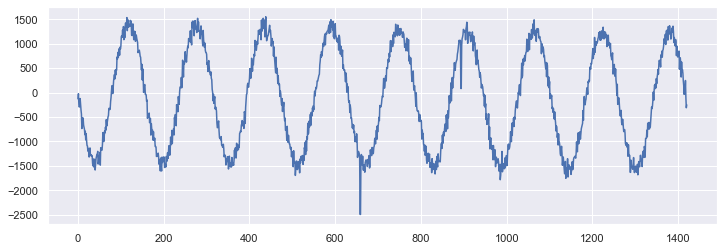

In [4]:
synth = pd.read_csv('data/synthetic_10.txt')
synth_tensor = torch.tensor(-1 * synth.value)
sns.lineplot(data=synth_tensor);
plt.show()

## Preprocess to Dataset/DataLoaders

In [5]:
window = 7
n_features = 1
factor = 10
emb_size = window * n_features * factor

seqs = preprocess.sequence(synth_tensor, window)
transform = preprocess.Difference()
train_data = data.SimpleDataset(seqs, transform=transform)
train_loader = DataLoader(train_data, shuffle=True)

## Initialize and Train New Model

In [6]:
model = networks.LSTMEncoderDecoder(n_features, emb_size)

In [7]:
criterion = nn.MSELoss(reduction='sum')
lr = 1e-4
loss = networks.train_encoder(model, 
                             epochs=2000, 
                             lr=lr, 
                             criterion=criterion,
                             trainload=train_loader,
                             testload=train_loader)

Training model on cpu


  0%|          | 0/2000 [00:00<?, ?it/s]

No improvement in 20 epochs. Interrupting training.
Best loss: 31185.909419618805
Loading best model weights.
Training complete.


## Visualize Loss

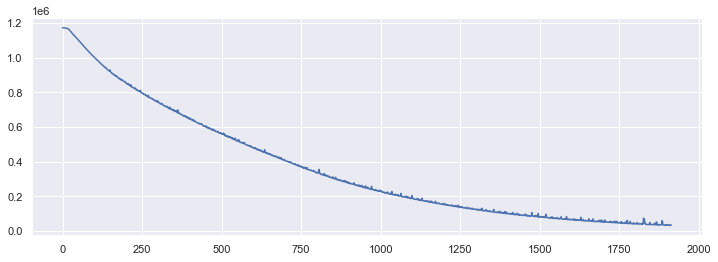

In [8]:
sns.lineplot(data=loss[0]);

In [9]:
torch.save(model.state_dict(), f'models/lstm_model_size={emb_size}_lr={lr}.pt')

# Visualize Reconstruction

In [10]:
# Get a random sample:
sample = seqs[30]

# apply difference transform
sample = transform(sample)

# add dimensions for batch size and # features
sample = sample.unsqueeze(0).unsqueeze(-1).float()

out = model(sample)

In [11]:
# invert difference transform
sample = transform.inverse(sample.squeeze())
out = transform.inverse(out.squeeze())

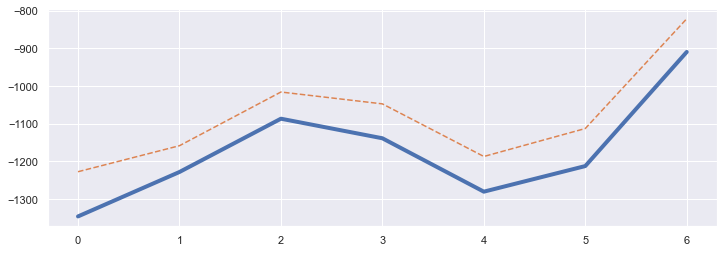

In [12]:
# plot original and reconstruction
plt.plot(sample.detach().numpy().squeeze(), '-', linewidth=4, label='Input')
plt.plot(out.detach().numpy().squeeze(), '--', label='Reconstructed');

## Run Inference on Data

In [13]:
# Run inference on all data.
reconstructed = torch.tensor([])
for seq in train_data:
    x = seq.unsqueeze(0).unsqueeze(-1).float()
    with torch.no_grad():
        x_hat = model(x)
        reconstructed = torch.cat((reconstructed, x_hat))
    

In [14]:
reconstructed = reconstructed.squeeze()

# # Invert difference transform
reconstructed = [transform.inverse(seq) for seq in reconstructed]

# Concatenate sub-sequences
reconstructed = torch.cat(tuple(reconstructed))

## Compute Anomaly Scores

In [15]:
# Get L1 Loss of whole data set.
criterion = nn.L1Loss(reduction='none')
loss = criterion(reconstructed, synth_tensor);

In [16]:
# Build cumulative density function from loss
cdf = ECDF(loss.squeeze())

# Get threshold
thresh = next(x for x in loss if cdf(x) > 0.99)

# get x, y coordinates for plotting anoms.
x = np.where(loss > thresh)[0]
y = loss[loss > thresh]

## Visualize Anomalies

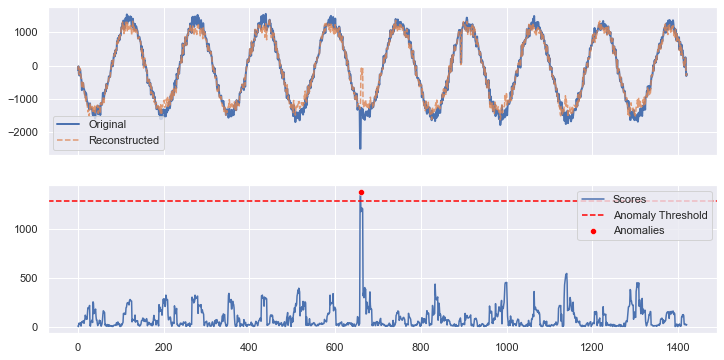

In [17]:
fig, ax, = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Reconstruction
sns.lineplot(data=synth_tensor, linestyle='-', linewidth=2, ax=ax[0], label="Original")
sns.lineplot(data=reconstructed, linestyle='--', alpha=0.8, ax=ax[0], label='Reconstructed')

# Anomaly detection
sns.lineplot(data=loss, label='Scores', ax=ax[1])
sns.scatterplot(x=x, y=y, color='red', ax=ax[1], label='Anomalies', zorder=3)
ax[1].axhline(y=thresh, c='red', linestyle='--', label='Anomaly Threshold')

plt.legend(loc='upper right')
plt.show()

## Use SPOT:

Initial threshold : 239.78545693960018
Number of peaks : 11
Grimshaw maximum log-likelihood estimation ... bounds0 -0.023182160438417327
bounds1 -1e-08
step 0.002107468221674302
bounds0 0.26179293830147304
bounds1 0.9548313361286169
step 0.06300349071155854
[done]
	γ = 0
	σ = 20.224204028937677
	L = 44.075681170067064
Extreme quantile (probability = 0.0001): 345.1799725296544


  0%|          | 0/821 [00:00<?, ?it/s]

bounds0 -0.023182160438417327
bounds1 -1e-08
step 0.002107468221674302
bounds0 0.26775286561823813
bounds1 1.039198633847533
step 0.07013143347539043
bounds0 -0.023182160438417327
bounds1 -1e-08
step 0.002107468221674302
bounds0 0.2687438535073225
bounds1 1.0542873836000952
step 0.07141304819025206
bounds0 -0.023182160438417327
bounds1 -1e-08
step 0.002107468221674302
bounds0 0.2736595529110745
bounds1 1.1342137524302027
step 0.07823219995628437
bounds0 -0.023182160438417327
bounds1 -1e-08
step 0.002107468221674302
bounds0 0.27762096626826943
bounds1 1.2055076166322296
step 0.08435333185126911
bounds0 -0.023182160438417327
bounds1 -1e-08
step 0.002107468221674302
bounds0 0.27767037819034696
bounds1 1.2064398519839414
step 0.08443358852669042
bounds0 -0.009089916705497704
bounds1 -1e-08
step 0.0008263551550452458
bounds0 0.292065273548135
bounds1 1.5351908556029759
step 0.11301141655044007
bounds0 -0.009089916705497704
bounds1 -1e-08
step 0.0008263551550452458
bounds0 0.2948741747849928

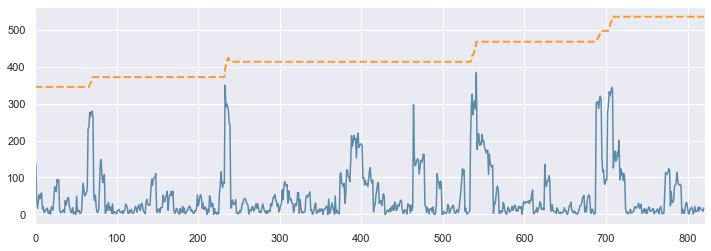

In [17]:
from models import spot

# Split data for initialization step
init_split = 0.25
init_index = int(0.25 * len(loss))
init_data = loss[:600].numpy()

# Remainder is data fro run
run_data = loss[600:].numpy()

# Risk threshold (probability)
q = 1e-4

# Initialize
sp = spot.SPOT()
sp.fit(init_data, run_data)
sp.initialize(level=0.98)

# Run
results = sp.run()

# Plot
fig = sp.plot(results);

In [18]:
min_idxs = synth_tensor.argsort()[:2]
synth_tensor[min_idxs]

tensor([-1781.4791, -1752.0976], dtype=torch.float64)

<AxesSubplot:>

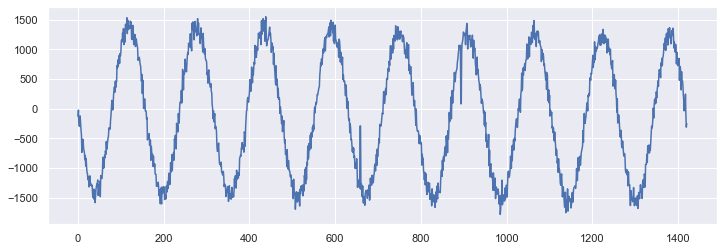

In [19]:
sns.lineplot(data=synth_tensor)